<a href="https://colab.research.google.com/github/ronupanchal/LogFileAnalysisExample/blob/master/Log_File_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

     |████████████████████████████████| 204.7MB 43kB/s 
     |████████████████████████████████| 204kB 6.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=e6ef57a031b4863b45a8c9a946c60777ae180b8c52144f81173ec3f2723f116b
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [2]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
   
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
#Change Directive
import os
os.chdir('/content/drive/My Drive/DS_Projects/NASA_access_log_Aug95/')

In [20]:
#get current part
os.getcwd()

'/content/drive/My Drive/DS_Projects/NASA_access_log_Aug95'

In [27]:
import sys
from math import sqrt
from pyspark.sql import SparkSession, functions, types, Row
import re

spark = SparkSession.builder.appName('correlate logs').getOrCreate()

assert sys.version_info >= (3, 4) # make sure we have Python 3.4+
assert spark.version >= '2.1' # make sure we have Spark 2.1+

In [28]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<_sre.SRE_Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<_sre.SRE_Match object; span=(25, 36), match=' in PySpark'> 25 36


In [35]:
import glob

raw_data_files = glob.glob('*.log')
raw_data_files

['access_log_Aug95.log']

In [39]:
base_df = spark.read.text("/content/drive/My Drive/DS_Projects/NASA_access_log_Aug95/access_log_Aug95.log")
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [40]:
type(base_df)

pyspark.sql.dataframe.DataFrame

In [41]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

In [42]:
base_df.show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839|
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                   |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                          |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0                           |


In [43]:
base_df_rdd.take(10)

[Row(value='in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='ix-esc-ca2-07.ix.netcom.com - - [01/Aug/1995:00:00:09 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1713'),
 Row(value='uplherc.upl.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='slppp6.intermind.net - - [01/Aug/1995:00:00:10 -0400] "GET /history/skylab/skylab.html HTTP/1.0" 200 1687'),
 Row(value='piweba4y.prodigy.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/l

### 1. How many data records are in your final dataset? 

Now that we have loaded and viewed our log data, let’s process and wrangle it.

**Data Wrangling**

In [44]:
print((base_df.count(), len(base_df.columns)))

(1569898, 1)


In [45]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839',
 'uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0',
 'ix-esc-ca2-07.ix.netcom.com - - [01/Aug/1995:00:00:09 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1713',
 'uplherc.upl.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0" 304 0',
 'slppp6.intermind.net - - [01/Aug/1995:00:00:10 -0400] "GET /history/skylab/skylab.html HTTP/1.0" 200 1687',
 'piweba4y.prodigy.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/launchmedium.gif HTTP/1.0" 200 11853',
 'slppp6.intermind.net - - [01/Aug/1995:00:00:11 -0400] "GET

In [46]:
#Extracting hostnames

host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['in24.inetnebr.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'uplherc.upl.com',
 'ix-esc-ca2-07.ix.netcom.com',
 'uplherc.upl.com',
 'slppp6.intermind.net',
 'piweba4y.prodigy.com',
 'slppp6.intermind.net',
 'slppp6.intermind.net',
 'ix-esc-ca2-07.ix.netcom.com',
 'slppp6.intermind.net',
 'uplherc.upl.com',
 '133.43.96.45']

In [47]:
#Extracting timestamps
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps


['01/Aug/1995:00:00:01 -0400',
 '01/Aug/1995:00:00:07 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:08 -0400',
 '01/Aug/1995:00:00:09 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:10 -0400',
 '01/Aug/1995:00:00:11 -0400',
 '01/Aug/1995:00:00:12 -0400',
 '01/Aug/1995:00:00:12 -0400',
 '01/Aug/1995:00:00:13 -0400',
 '01/Aug/1995:00:00:14 -0400',
 '01/Aug/1995:00:00:16 -0400']

In [48]:
#Extracting HTTP request method, URIs, and protocol
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol


[('GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/images/ksclogo-medium.gif', 'HTTP/1.0'),
 ('GET', '/images/MOSAIC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/USA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/launch-logo.gif', 'HTTP/1.0'),
 ('GET', '/images/WORLD-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/history/skylab/skylab.html', 'HTTP/1.0'),
 ('GET', '/images/launchmedium.gif', 'HTTP/1.0'),
 ('GET', '/history/skylab/skylab-small.gif', 'HTTP/1.0'),
 ('GET', '/images/ksclogosmall.gif', 'HTTP/1.0'),
 ('GET', '/history/apollo/images/apollo-logo1.gif', 'HTTP/1.0'),
 ('GET', '/history/apollo/images/apollo-logo.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-69/mission-sts-69.html', 'HTTP/1.0')]

In [49]:
#Extracting HTTP status codes
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '304', '304', '304', '304', '200', '304', '200', '200', '200', '200', '200', '200', '304', '200']


In [50]:
# Extracting HTTP response content size
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['1839', '0', '0', '0', '0', '1713', '0', '1687', '11853', '9202', '3635', '1173', '3047', '0', '10566']


**Putting it all together**

In [51]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|   in24.inetnebr.com|01/Aug/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|                   /|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|
|ix-esc-ca2-07.ix....|01/Aug/1995:00:00...|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/WORLD-log...|HTTP/1.0|   304|    

**Finding missing values**

In [52]:
(base_df
    .filter(base_df['value']
                .isNull())
    .count())

0

All good! Now, if our data parsing and extraction worked properly, we should not have any rows with potential null values. Let’s try and put that to test:

In [53]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()|
                             logs_df['timestamp'].isNull() |                            
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull())
                            
bad_rows_df.count()

14178

In [56]:
bad_rows_df.head(5)

[Row(host='gw1.att.com', timestamp='01/Aug/1995:00:03:53 -0400', method='GET', endpoint='/shuttle/missions/sts-73/news', protocol='HTTP/1.0', status=302, content_size=None),
 Row(host='js002.cc.utsunomiya-u.ac.jp', timestamp='01/Aug/1995:00:07:33 -0400', method='GET', endpoint='/shuttle/resources/orbiters/discovery.gif', protocol='HTTP/1.0', status=404, content_size=None),
 Row(host='tia1.eskimo.com', timestamp='01/Aug/1995:00:28:41 -0400', method='GET', endpoint='/pub/winvn/release.txt', protocol='HTTP/1.0', status=404, content_size=None),
 Row(host='itws.info.eng.niigata-u.ac.jp', timestamp='01/Aug/1995:00:38:01 -0400', method='GET', endpoint='/ksc.html/facts/about_ksc.html', protocol='HTTP/1.0', status=403, content_size=None),
 Row(host='grimnet23.idirect.com', timestamp='01/Aug/1995:00:50:12 -0400', method='GET', endpoint='/www/software/winvn/winvn.html', protocol='HTTP/1.0', status=404, content_size=None)]

### Finding null counts

In [54]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       14178|
+----+---------+------+--------+--------+------+------------+



### Handling nulls in HTTP content size

In [58]:
regexp_extract('value', r'\s(\d+)$', 1).cast('integer').alias('content_size')

Column<b'CAST(regexp_extract(value, \\s(\\d+)$, 1) AS INT) AS `content_size`'>

In [59]:
# find the records with potential missing content sizes in our base DataFrame:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

14178

In [60]:
null_content_size_df.take(10)

[Row(value='gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -'),
 Row(value='js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -'),
 Row(value='tia1.eskimo.com - - [01/Aug/1995:00:28:41 -0400] "GET /pub/winvn/release.txt HTTP/1.0" 404 -'),
 Row(value='itws.info.eng.niigata-u.ac.jp - - [01/Aug/1995:00:38:01 -0400] "GET /ksc.html/facts/about_ksc.html HTTP/1.0" 403 -'),
 Row(value='grimnet23.idirect.com - - [01/Aug/1995:00:50:12 -0400] "GET /www/software/winvn/winvn.html HTTP/1.0" 404 -'),
 Row(value='miriworld.its.unimelb.edu.au - - [01/Aug/1995:01:04:54 -0400] "GET /history/history.htm HTTP/1.0" 404 -'),
 Row(value='ras38.srv.net - - [01/Aug/1995:01:05:14 -0400] "GET /elv/DELTA/uncons.htm HTTP/1.0" 404 -'),
 Row(value='cs1-06.leh.ptd.net - - [01/Aug/1995:01:17:38 -0400] "GET /sts-71/launch/" 404 -'),
 Row(value='www-b2.proxy.aol.com - - [01/Aug/1995:01:22:07 -0400] "GET 

In [61]:
logs_df.head(10)

[Row(host='in24.inetnebr.com', timestamp='01/Aug/1995:00:00:01 -0400', method='GET', endpoint='/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', protocol='HTTP/1.0', status=200, content_size=1839),
 Row(host='uplherc.upl.com', timestamp='01/Aug/1995:00:00:07 -0400', method='GET', endpoint='/', protocol='HTTP/1.0', status=304, content_size=0),
 Row(host='uplherc.upl.com', timestamp='01/Aug/1995:00:00:08 -0400', method='GET', endpoint='/images/ksclogo-medium.gif', protocol='HTTP/1.0', status=304, content_size=0),
 Row(host='uplherc.upl.com', timestamp='01/Aug/1995:00:00:08 -0400', method='GET', endpoint='/images/MOSAIC-logosmall.gif', protocol='HTTP/1.0', status=304, content_size=0),
 Row(host='uplherc.upl.com', timestamp='01/Aug/1995:00:00:08 -0400', method='GET', endpoint='/images/USA-logosmall.gif', protocol='HTTP/1.0', status=304, content_size=0),
 Row(host='ix-esc-ca2-07.ix.netcom.com', timestamp='01/Aug/1995:00:00:09 -0400', method='GET', endpoint='/images/launch-logo.gif', protoco

In [62]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [83]:
count=col("status").cast("integer")
print(count) 

Column<b'CAST(status AS INT)'>


In [88]:
#count = logs_df.status.value_counts() 
#print(count) 

logs_df.cube("status").count().show()

+------+-------+
|status|  count|
+------+-------+
|   302|  26497|
|   200|1398988|
|  null|1569898|
|   501|     27|
|   404|  10056|
|   403|    171|
|   304| 134146|
|   500|      3|
|   400|     10|
+------+-------+



In [90]:
pip install pyspark_dist_explore

(array([[8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [6., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 1.]]),
 array([3.00000000e+00, 7.84977500e+04, 1.56992500e+05, 2.35487250e+05,
        3.13982000e+05, 3.92476750e+05, 4.70971500e+05, 5.49466250e+05,
        6.27961000e+05, 7.06455750e+05, 7.84950500e+05, 8.63445250e+05,
        9.41940000e+05, 1.02043475e+06, 1.09892950e+06, 1.17742425e+06,
        1.25591900e+06, 1.33441375e+06, 1.41290850e+06, 1.49140325e+06,
        1.56989800e+06]),
 <a list of 2 Lists of Patches objects>)

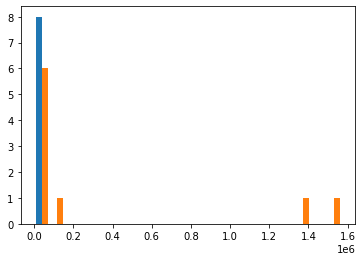

In [97]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

df=logs_df.cube("status").count()

fig, ax = plt.subplots()
hist(ax, df, bins = 20)

In [67]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = true)



In [71]:
logs_df.freqItems

<bound method DataFrame.freqItems of DataFrame[host: string, timestamp: string, method: string, endpoint: string, protocol: string, status: int, content_size: int]>

In [75]:
# Calculate statistics based on the content size.
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.show()

+-------+-----------------+
|summary|     content_size|
+-------+-----------------+
|  count|          1555720|
|   mean| 17244.9678759674|
| stddev|68244.03865948405|
|    min|                0|
|    max|          3421948|
+-------+-----------------+



Reference
1) https://opensource.com/article/19/5/log-data-apache-spark

2) https://www.kaggle.com/vinzzhang/server-log-correlation

3) https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/4438435960036599/2202577924924539/latest.html
